### 1. Introducción: Presentación de la serie a analizar.

Los datos elegidos corresponden a la evolución de la demanda eléctrica en España. Han sido obtenidos de la página oficial de la Red Eléctrica Española (https://www.ree.es). Se ha utilizado la documentación de la API disponible (https://www.ree.es/es/apidatos) para solicitar los datos diarios desde el año 2011 a 2023 (ver código de python en **api.py**). De esta manera, se ha obtenido un csv por año con los datos diarios de la demanda eléctrica.  

Una vez obtenidos los datos diarios, se han llevado a cabo un proceso de limpieza del formato de las fechas (ver código en **cleaning.py**) y concatenación de los datos en un solo archivo. Luego se han seleccionado los valores máximos de cada mes (ver **maximos.py**) para adecuarlo a la tarea, ya que se requería un conjunto de datos de unos 150 datos observados:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
df = pd.read_csv('demanda_electrica_maxima_mes_2011_2023.csv', index_col='Fecha', parse_dates=True)

In [3]:
df.shape

(156, 1)

In [4]:
df.head()

,Demanda
Fecha,
2011-01-01,925838.099
2011-02-01,896370.497
2011-03-01,872249.280
2011-04-01,739283.981
2011-05-01,768988.409


In [5]:
df.tail()

,Demanda
Fecha,
2023-08-01,800908.724
2023-09-01,712298.126
2023-10-01,693331.667
2023-11-01,731976.345
2023-12-01,774527.052


In [6]:
df.dtypes

Demanda    float64
dtype: object

### 2. Representación gráfica y descomposición estacional (si tuviera comportamiento estacional)

In [7]:
plt.rc("figure", figsize=(15,5))
plt.rc("font", size=9)

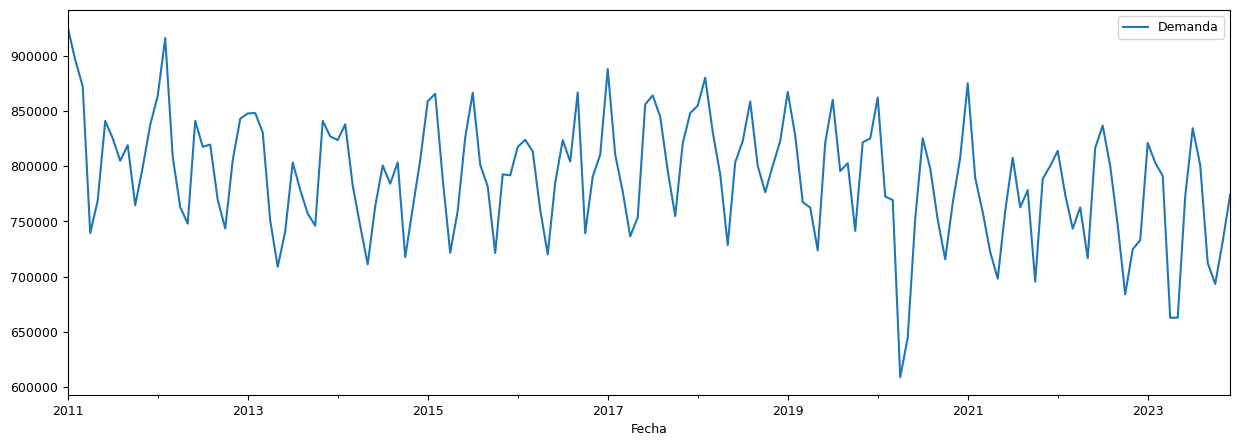

In [8]:
df.plot()
plt.show()

Dado que en la gráfica anterior no parece que los datos cambien de forma proporcionalmente a lo largo del tiempo, no parece adecuado un modelo multiplicativo:

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose

add_decomposition = seasonal_decompose(df['Demanda'], model='additive', period=12)

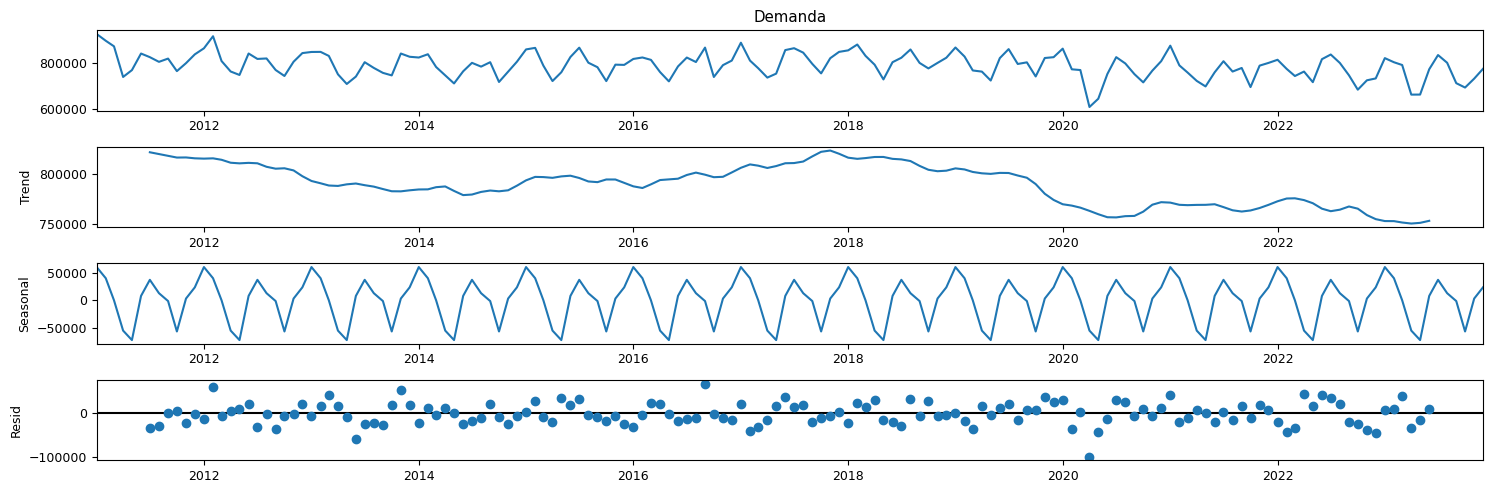

In [10]:
descomposicion_grafica = add_decomposition.plot()

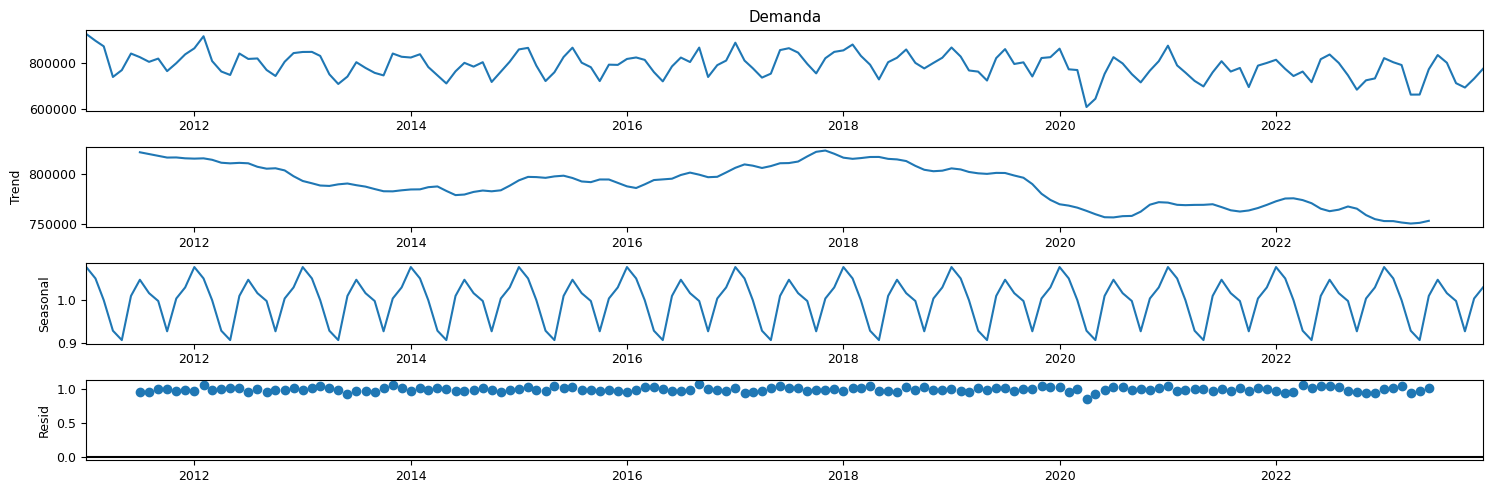

In [11]:
mul_decomposition = seasonal_decompose(df['Demanda'], model='multiplicative', period=12)
descomposicion_grafica = mul_decomposition.plot()

### 3. Para comprobar la eficacia de los métodos de predicción que vamos a hacer en los siguientes apartados, reservamos los último datos observados (test) un periodo en las series estacionales o aproximadamente 10 observaciones para comparar con las predicciones realizadas por cada uno de los métodos. 

Se comprueba si se ha detectado automáticamente la frecuencia de los índices:

In [12]:
df.index 

DatetimeIndex(['2011-01-01', '2011-02-01', '2011-03-01', '2011-04-01',
               '2011-05-01', '2011-06-01', '2011-07-01', '2011-08-01',
               '2011-09-01', '2011-10-01',
               ...
               '2023-03-01', '2023-04-01', '2023-05-01', '2023-06-01',
               '2023-07-01', '2023-08-01', '2023-09-01', '2023-10-01',
               '2023-11-01', '2023-12-01'],
              dtype='datetime64[ns]', name='Fecha', length=156, freq=None)

Dado que freq=None, hay que especificar la frecuencia manualmente:

In [13]:
df.index.freq = 'MS' # MS es Month Start

A continuación, se construyen los conjuntos de datos train y test:

In [14]:
N_test = 12

In [15]:
train = df.iloc[:-N_test]
test = df.iloc[-N_test:]

In [16]:
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

In [17]:
train

,Demanda
Fecha,
2011-01-01,925838.099
2011-02-01,896370.497
2011-03-01,872249.280
2011-04-01,739283.981
2011-05-01,768988.409
...,...
2022-08-01,800030.828
2022-09-01,746416.150
2022-10-01,683996.794


In [18]:
test

,Demanda
Fecha,
2023-01-01,821055.295
2023-02-01,803175.498
2023-03-01,791155.923
2023-04-01,662633.383
2023-05-01,662853.882
2023-06-01,772762.890
2023-07-01,834382.753
2023-08-01,800908.724
2023-09-01,712298.126


### 4. Encontrar el modelo de suavizado exponencial más adecuado, mostrando una tabla con los estimadores de los parámetros del modelo elegido. Para dicho modelo, representar gráficamente la serie observada y la suavizada con las predicciones para el periodo TEST. Mostrar una tabla con las predicciones. 

In [19]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
import itertools
from sklearn.metrics import mean_squared_error

A) Modelo de suavizado exponencial simple

C:\Users\Usuario\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


<Axes: xlabel='Fecha'>

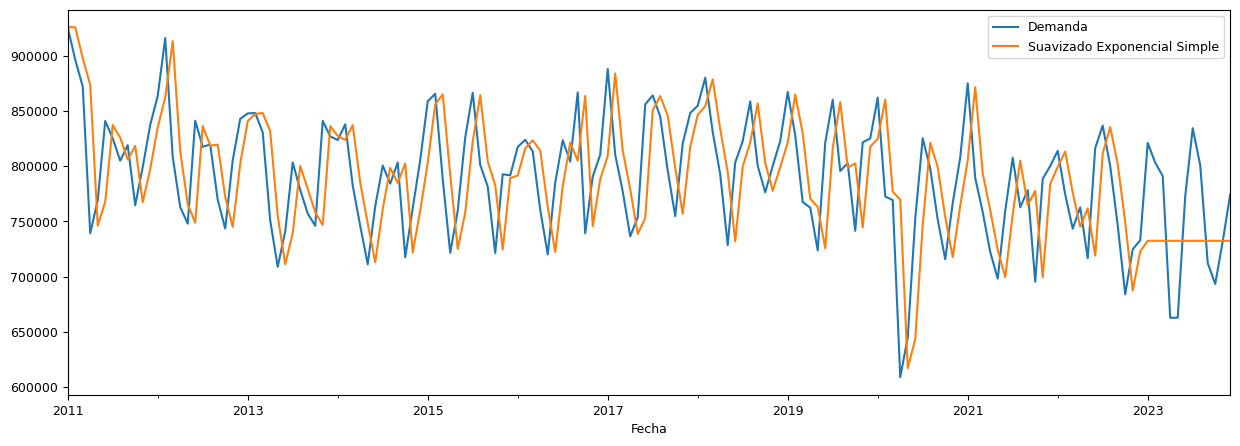

In [20]:
ses = SimpleExpSmoothing(train['Demanda'], initialization_method='legacy-heuristic')
res_ses = ses.fit()

df.loc[train_idx,'Suavizado Exponencial Simple'] = res_ses.fittedvalues
df.loc[test_idx, 'Suavizado Exponencial Simple'] = res_ses.forecast(N_test)

df[['Demanda', 'Suavizado Exponencial Simple']].plot()

In [21]:
print("Root Mean Square Error (TRAIN): ", mean_squared_error(train['Demanda'],res_ses.fittedvalues, squared=False))
print("Root Mean Square Error (TEST): ", mean_squared_error(test['Demanda'],res_ses.forecast(N_test), squared=False))

Root Mean Square Error (TRAIN):  52478.84050379847
Root Mean Square Error (TEST):  62211.7164045061


B) Modelo lineal de Holt:

C:\Users\Usuario\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


<Axes: xlabel='Fecha'>

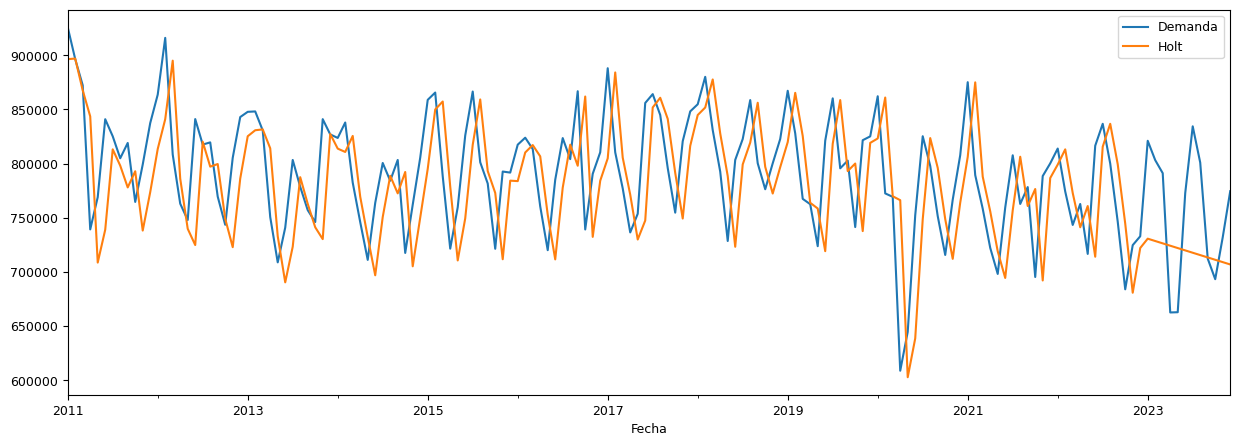

In [22]:
holt = Holt(train['Demanda'], initialization_method='legacy-heuristic')
res_h = holt.fit()

df.loc[train_idx, 'Holt'] = res_h.fittedvalues
df.loc[test_idx, 'Holt'] = res_h.forecast(N_test)

df[['Demanda', 'Holt']].plot()

In [23]:
print("Root Mean Square Error (TRAIN): ", mean_squared_error(train['Demanda'],res_h.fittedvalues, squared=False))
print("Root Mean Square Error (TEST): ", mean_squared_error(test['Demanda'],res_h.forecast(N_test), squared=False))

Root Mean Square Error (TRAIN):  54085.51425732554
Root Mean Square Error (TEST):  67282.5463381124


C) Modelo de Holt-Winters

In [24]:
h= 12 #horizonte de pronóstico
steps = 13
NTest = len(df)-h-steps +1

Listas con los hiperparámetros a probar:

In [25]:
lista_tendencias = ['add', 'mul']
lista_estacionalidades = ['add','mul']
lista_tendencia_amortiguada = [True,False]
lista_init_methods = ['estimated','heuristic','legacy-heuristic']
lista_boxcox = [True, False,0]

In [26]:
def walkforward(tipo_tendencia, tipo_estacionalidad, tendencia_amortiguada, init_method, use_boxcox, debug=False):
    errores = []
    ultimo = False # marcador que nos dirá si hemos procesado la última fila del dataframe
    pasos_completados = 0 # cuando se complete el for, será el mismo número que le hemos puesto en la variable steps

    for end_of_train in range(NTest, len(df)-h+1):
        train = df.iloc[:end_of_train]
        test = df.iloc[end_of_train:end_of_train + h]

        if test.index[-1] == df.index[-1]:
            ultimo = True
        
        pasos_completados +=1

        hw = ExponentialSmoothing(train['Demanda'], initialization_method= init_method, trend=tipo_tendencia,damped_trend=tendencia_amortiguada, seasonal=tipo_estacionalidad, seasonal_periods=12, use_boxcox=use_boxcox)
        res_hw = hw.fit()


        fcast = res_hw.forecast(h)
        error = mean_squared_error(test['Demanda'], fcast, squared=False)
        errores.append(error)

    if debug:
        print("Último registro: ", ultimo)
        print("Pasos completados: ", pasos_completados)

    return np.mean(errores)

Se itera sobre todos los posibles conjuntos de hiperparámetros (grid search):

In [27]:
tupla_de_listas_de_opciones = (lista_tendencias, lista_estacionalidades, lista_tendencia_amortiguada, lista_init_methods, lista_boxcox, )
tupla_de_listas_de_opciones

(['add', 'mul'],
 ['add', 'mul'],
 [True, False],
 ['estimated', 'heuristic', 'legacy-heuristic'],
 [True, False, 0])

In [28]:
mejor_score = float('inf')
mejor_opcion = None

for x in itertools.product(*tupla_de_listas_de_opciones):
    score = walkforward(*x)

    if score < mejor_score:
        print("La mejor score hasta el momento: ", score)
        mejor_score = score
        mejor_opcion = x

C:\Users\Usuario\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Usuario\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Usuario\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Usuario\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Usuario\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Usuario\AppData\

C:\Users\Usuario\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Usuario\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Usuario\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Usuario\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Usuario\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Usuario\AppData\

La mejor score hasta el momento:  36060.12568815049


C:\Users\Usuario\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Usuario\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Usuario\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Usuario\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Usuario\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Usuario\AppData\

La mejor score hasta el momento:  35375.78776757202


C:\Users\Usuario\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Usuario\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Usuario\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Usuario\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Usuario\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Usuario\AppData\

La mejor score hasta el momento:  35029.338645656346


C:\Users\Usuario\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Usuario\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Usuario\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Usuario\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Usuario\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Usuario\AppData\

La mejor score hasta el momento:  34874.541943558346


C:\Users\Usuario\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Usuario\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Usuario\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Usuario\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Usuario\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Usuario\AppData\

In [29]:
print("Mejor puntuación (Root Mean Squared Error): " ,mejor_score)
print("Mejores opciones de hiperparámetros: ",mejor_opcion)

Mejor puntuación (Root Mean Squared Error):  34874.541943558346
Mejores opciones de hiperparámetros:  ('mul', 'add', False, 'estimated', True)


In [30]:
holtwinters = ExponentialSmoothing(train['Demanda'],trend='mul', seasonal='add', damped_trend=False, initialization_method='estimated', use_boxcox=True)
res_hw = holtwinters.fit()

df.loc[train_idx, 'Holt-Winters'] = res_hw.fittedvalues
df.loc[test_idx, 'Holt-Winters'] = res_hw.forecast(N_test)

#df[['Demanda', 'Holt-Winters']].plot()

C:\Users\Usuario\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


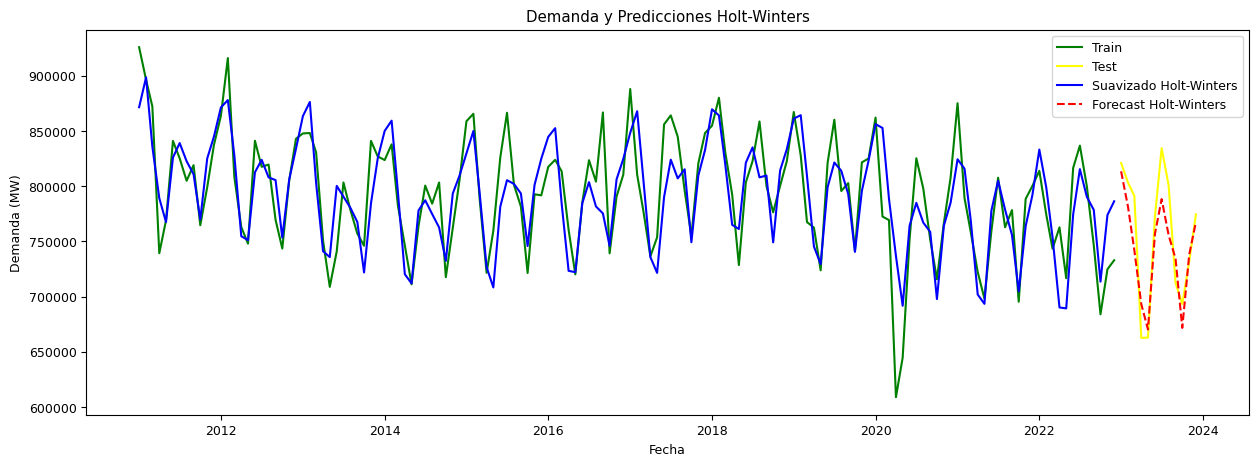

In [31]:

plt.plot(df.index[train_idx], df.loc[train_idx, 'Demanda'], label='Train', color='green')

plt.plot(df.index[test_idx], df.loc[test_idx, 'Demanda'], label='Test', color='yellow')

plt.plot(df.index[train_idx], df.loc[train_idx, 'Holt-Winters'], label='Suavizado Holt-Winters', color='blue')

plt.plot(df.index[test_idx], df.loc[test_idx, 'Holt-Winters'], label='Forecast Holt-Winters', color='red', linestyle='--')

plt.legend()

plt.title('Demanda y Predicciones Holt-Winters')
plt.xlabel('Fecha')
plt.ylabel('Demanda (MW)')

plt.show()

A continuación se muestran los parámetros del modelo ajustado con un formato de tabla:

In [32]:
from tabulate import tabulate

In [33]:
headers = ['Nombre', 'Param', 'Valor', 'Optimizado']

table_str=tabulate(res_hw.params_formatted, headers, tablefmt='fancy_grid')

print(table_str)

╒════════════════════╤═════════╤══════════════╤══════════════╕
│ Nombre             │ Param   │        Valor │ Optimizado   │
╞════════════════════╪═════════╪══════════════╪══════════════╡
│ smoothing_level    │ alpha   │  0.181786    │ True         │
├────────────────────┼─────────┼──────────────┼──────────────┤
│ smoothing_trend    │ beta    │  0.0001      │ True         │
├────────────────────┼─────────┼──────────────┼──────────────┤
│ smoothing_seasonal │ gamma   │  0.157349    │ True         │
├────────────────────┼─────────┼──────────────┼──────────────┤
│ initial_level      │ l.0     │  2.40888e+13 │ True         │
├────────────────────┼─────────┼──────────────┼──────────────┤
│ initial_trend      │ b.0     │  0.997414    │ True         │
├────────────────────┼─────────┼──────────────┼──────────────┤
│ initial_seasons.0  │ s.0     │  3.45853e+12 │ True         │
├────────────────────┼─────────┼──────────────┼──────────────┤
│ initial_seasons.1  │ s.1     │  4.78985e+12 │ True   

Por último, la tabla con las predicciones:

In [34]:
predicciones_df = df.loc[test_idx, ['Demanda', 'Holt-Winters']]
predicciones_df['Fecha'] = predicciones_df.index
predicciones_df = predicciones_df[['Fecha', 'Demanda', 'Holt-Winters']]

table_str2=tabulate(predicciones_df, 'keys', tablefmt='fancy_grid', showindex=False)

print(table_str2)

╒═════════════════════╤═══════════╤════════════════╕
│ Fecha               │   Demanda │   Holt-Winters │
╞═════════════════════╪═══════════╪════════════════╡
│ 2023-01-01 00:00:00 │    821055 │         813473 │
├─────────────────────┼───────────┼────────────────┤
│ 2023-02-01 00:00:00 │    803175 │         781108 │
├─────────────────────┼───────────┼────────────────┤
│ 2023-03-01 00:00:00 │    791156 │         742060 │
├─────────────────────┼───────────┼────────────────┤
│ 2023-04-01 00:00:00 │    662633 │         693285 │
├─────────────────────┼───────────┼────────────────┤
│ 2023-05-01 00:00:00 │    662854 │         670198 │
├─────────────────────┼───────────┼────────────────┤
│ 2023-06-01 00:00:00 │    772763 │         756836 │
├─────────────────────┼───────────┼────────────────┤
│ 2023-07-01 00:00:00 │    834383 │         788335 │
├─────────────────────┼───────────┼────────────────┤
│ 2023-08-01 00:00:00 │    800909 │         755769 │
├─────────────────────┼───────────┼───────────

### 5. Representar la serie y los correlogramas. Según el resultado de los correlogramas, decidir qué modelo puede ser ajustado. Ajustar el modelo adecuado comprobando que sus residuales están incorrelados.  
### (Sintaxis, tablas de los parámetros estimados y gráficos.)

In [35]:
from statsmodels.tsa.stattools import adfuller #test AUGMENTED DICKEY-FULLER
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

In [36]:
def adf(datos):
    res = adfuller(datos)
    print('Estadístico T: ', res[0])
    print('p-valor: ', res[1])

    if res[1] < 0.05:
        print('Estacionario')
    else:
        print('No estacionario')

In [37]:
adf(df['Demanda'])

Estadístico T:  -1.2038513389392718
p-valor:  0.6719367726771039
No estacionario


C:\Users\Usuario\AppData\Roaming\Python\Python311\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


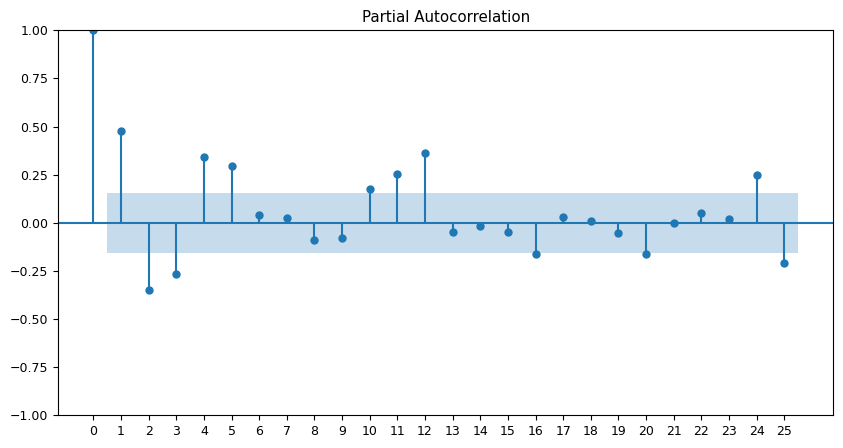

In [38]:
fig, ax = plt.subplots(figsize=(10,5))
plot_pacf(df['Demanda'], ax = ax, lags=25)
ax.set_xticks(range(26))
ax.set_xticklabels(range(26))
plt.show()


In [39]:
from statsmodels.tsa.stattools import pacf,acf
pacf_values = pacf(df['Demanda'], nlags=25)
pacf_list = list(pacf_values)
pacf_list

[1.0,
 0.47630677058077264,
 -0.3484499598794263,
 -0.26423304338540676,
 0.33920131864440656,
 0.2932631062404817,
 0.03859491529917851,
 0.02608852403858371,
 -0.08750562197908437,
 -0.0772979334489989,
 0.1729233558252195,
 0.25424242197508623,
 0.3607504609962571,
 -0.04621277006768097,
 -0.015132300380609807,
 -0.04594294797105833,
 -0.16264027028593572,
 0.030683685901143634,
 0.00854100892647636,
 -0.050825267139836615,
 -0.164145209514067,
 -0.0032598233348453435,
 0.05130336184792275,
 0.0204593986927524,
 0.2462552311951853,
 -0.20826527293063216]

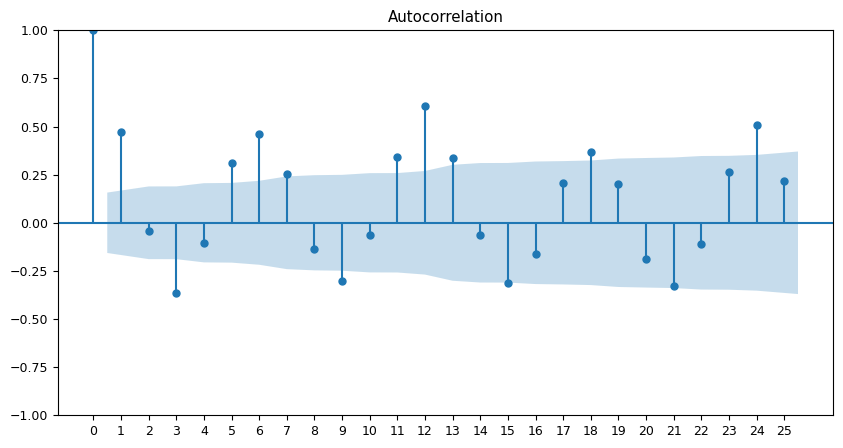

In [40]:
fig, ax = plt.subplots(figsize=(10,5))
plot_acf(df['Demanda'], ax = ax, lags=25)
ax.set_xticks(range(26))
ax.set_xticklabels(range(26))
plt.show()

In [41]:
acf_values = acf(df['Demanda'], nlags=25)
acf_list = list(acf_values)
acf_list

[1.0,
 0.47325352205140875,
 -0.04198437438617352,
 -0.3655992097384173,
 -0.10623760530281938,
 0.30875454568692934,
 0.4605194126175063,
 0.2516376413714429,
 -0.13429242366643213,
 -0.30086725843082823,
 -0.06530816431348965,
 0.3413396440246162,
 0.6091104607992344,
 0.3381829780575332,
 -0.06275851853539141,
 -0.3119106743597485,
 -0.16420941622819024,
 0.20428629810847093,
 0.3652130106255845,
 0.20150003979375677,
 -0.18881517358833028,
 -0.32746792381038964,
 -0.11230929038938227,
 0.26346267948206525,
 0.5086492829371277,
 0.21689403410581715]

In [42]:
df['diffDemanda'] = df['Demanda'].diff()

In [43]:
adf(df['diffDemanda'].dropna())

Estadístico T:  -9.982291321192175
p-valor:  2.0992134407437767e-17
Estacionario


<Axes: xlabel='Fecha'>

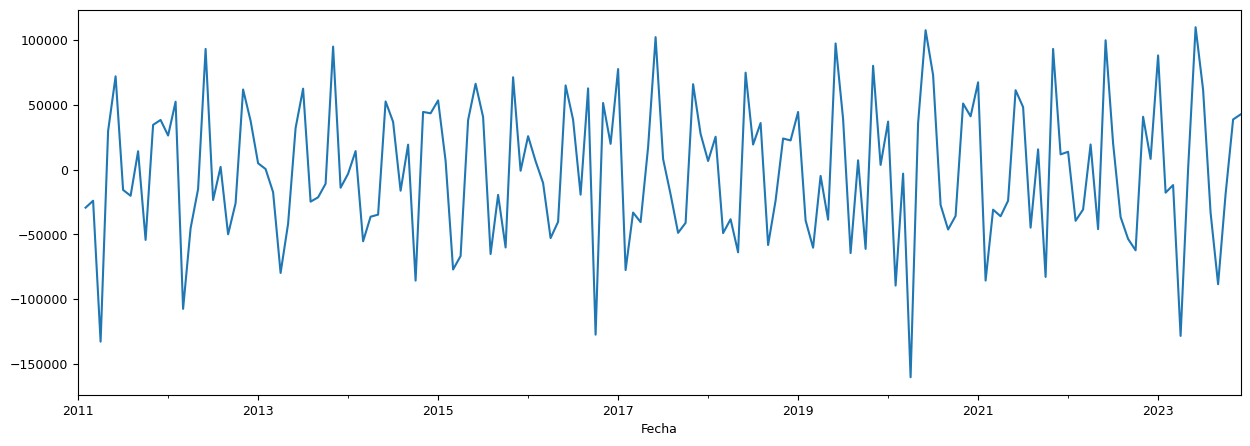

In [44]:
df['diffDemanda'].plot()

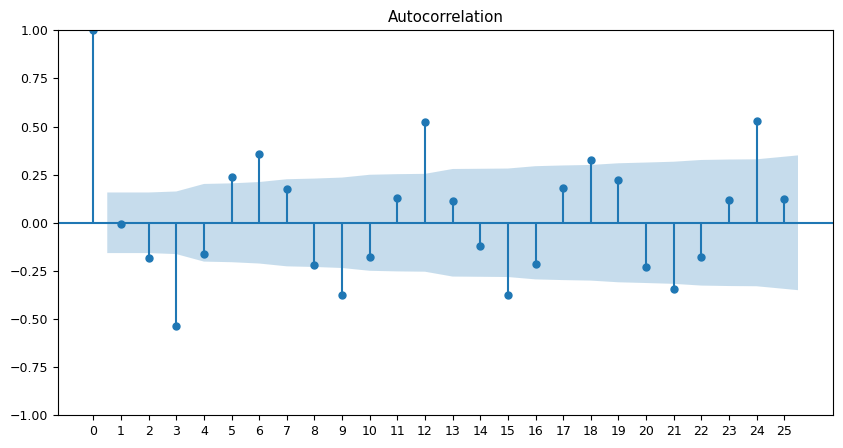

In [45]:
fig, ax = plt.subplots(figsize=(10,5))
plot_acf(df['diffDemanda'].dropna(), ax = ax, lags=25)
ax.set_xticks(range(26))
ax.set_xticklabels(range(26))
plt.show()

C:\Users\Usuario\AppData\Roaming\Python\Python311\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


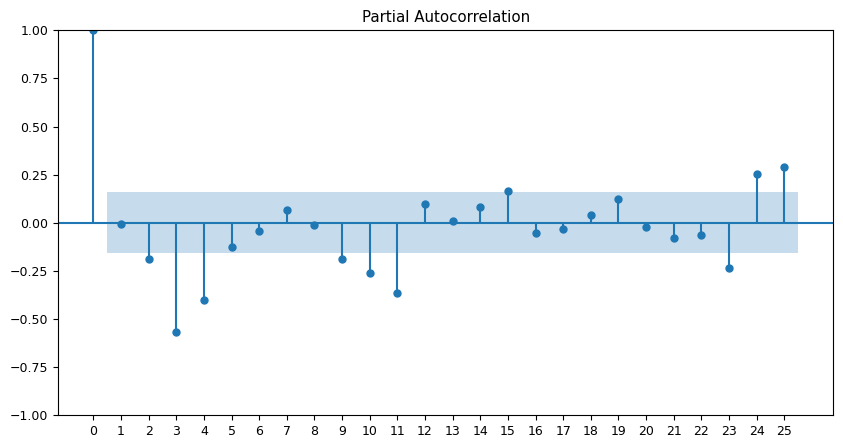

In [46]:
fig, ax = plt.subplots(figsize=(10,5))
plot_pacf(df['diffDemanda'].dropna(), ax = ax, lags=25)
ax.set_xticks(range(26))
ax.set_xticklabels(range(26))
plt.show()

In [47]:
df['diff3Demanda'] = df['Demanda'].diff(3)

In [48]:
adf(df['diff3Demanda'].dropna())

Estadístico T:  -7.325616076012262
p-valor:  1.1631896667255753e-10
Estacionario


<Axes: xlabel='Fecha'>

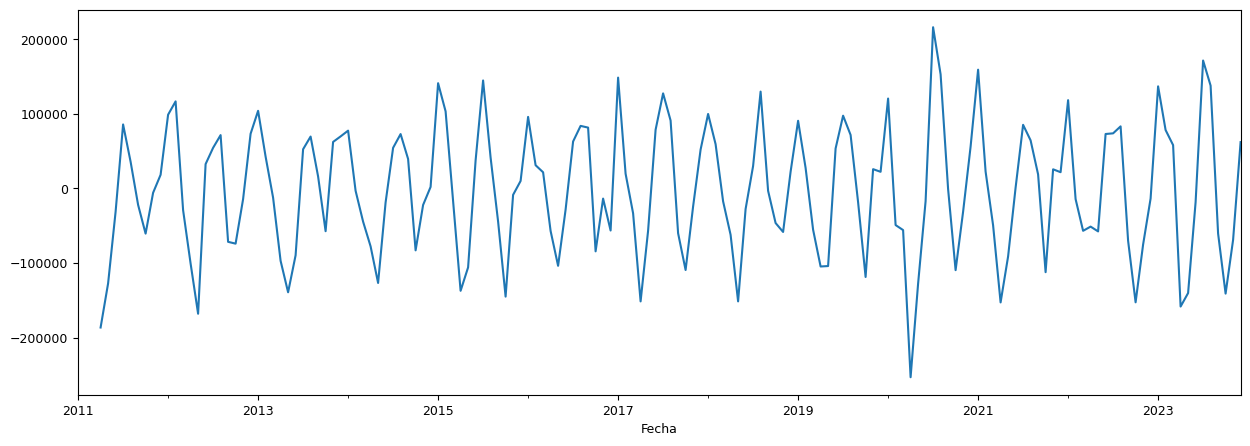

In [49]:
df['diff3Demanda'].plot()

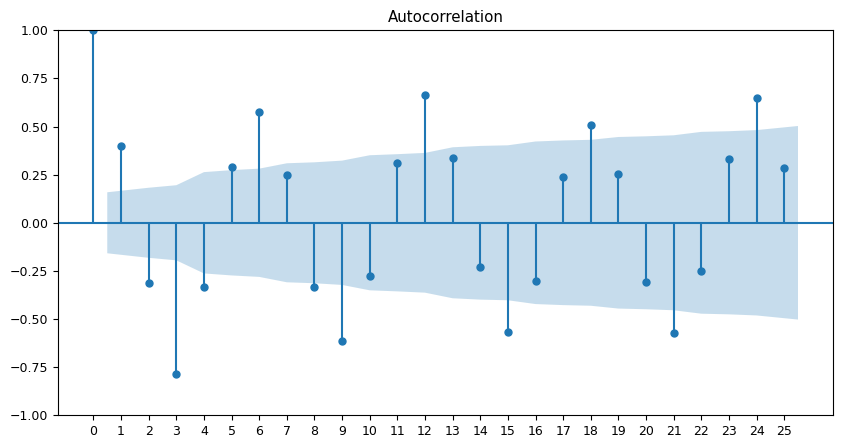

In [50]:
fig, ax = plt.subplots(figsize=(10,5))
plot_acf(df['diff3Demanda'].dropna(), ax = ax, lags=25)
ax.set_xticks(range(26))
ax.set_xticklabels(range(26))
plt.show()

C:\Users\Usuario\AppData\Roaming\Python\Python311\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


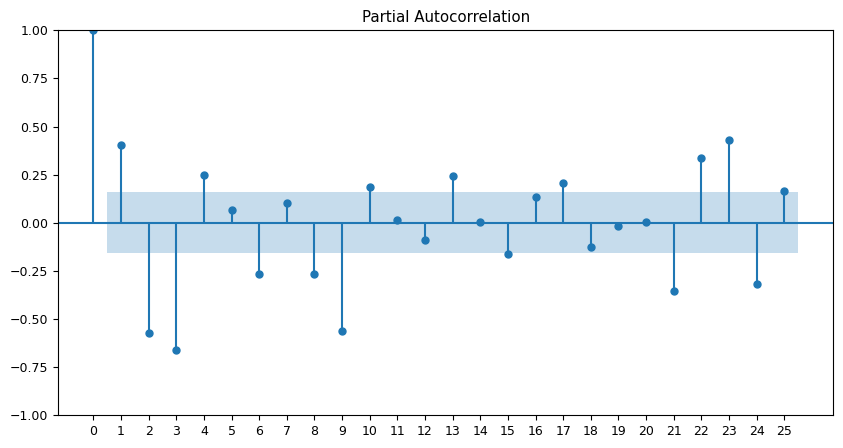

In [51]:
fig, ax = plt.subplots(figsize=(10,5))
plot_pacf(df['diff3Demanda'].dropna(), ax = ax, lags=25)
ax.set_xticks(range(26))
ax.set_xticklabels(range(26))
plt.show()

Estadístico T:  -7.387576670873028
p-valor:  8.160002023954731e-11
Estacionario


<Axes: xlabel='Fecha'>

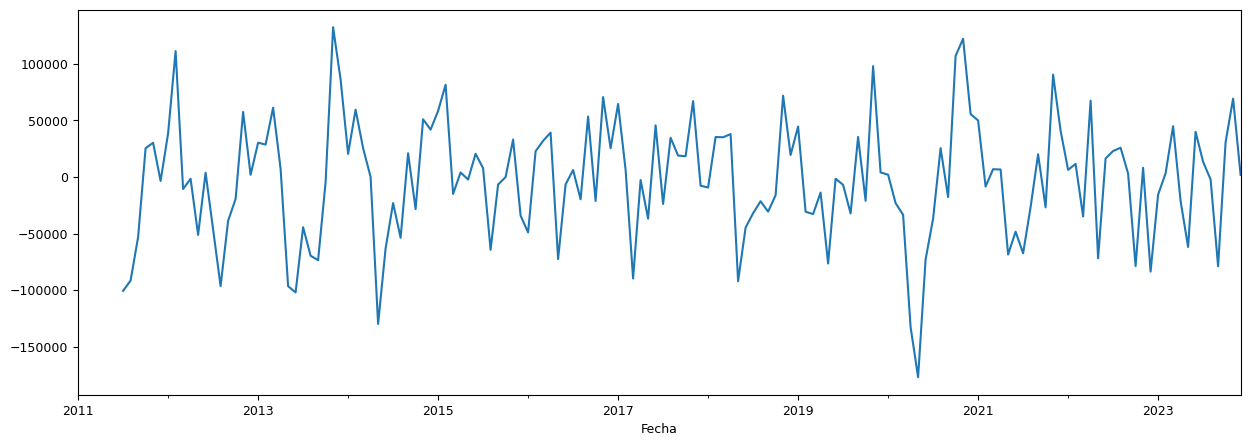

In [52]:
df['diff6Demanda'] = df['Demanda'].diff(6)
adf(df['diff6Demanda'].dropna())
df['diff6Demanda'].plot()

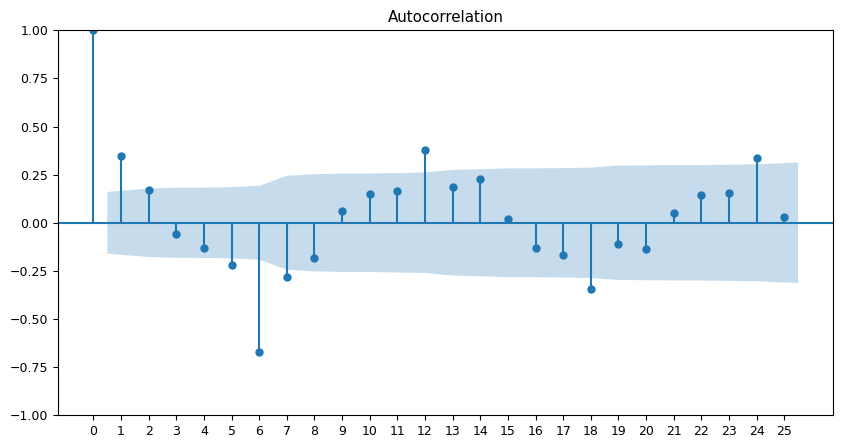

In [53]:
fig, ax = plt.subplots(figsize=(10,5))
plot_acf(df['diff6Demanda'].dropna(), ax = ax, lags=25)
ax.set_xticks(range(26))
ax.set_xticklabels(range(26))
plt.show()

C:\Users\Usuario\AppData\Roaming\Python\Python311\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


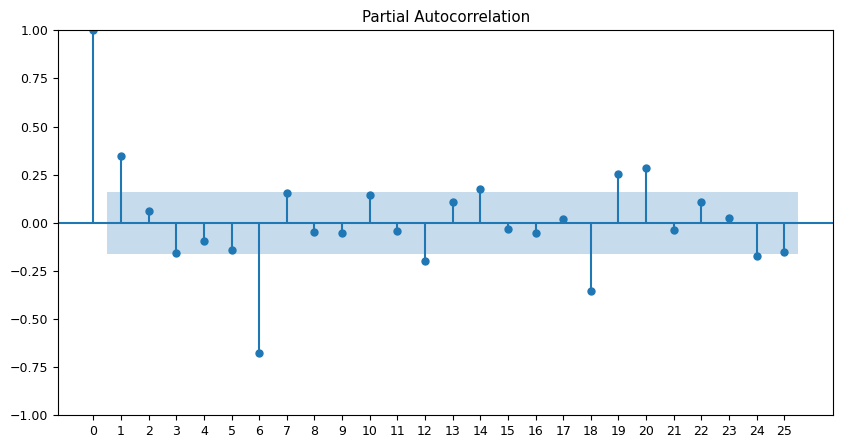

In [54]:
fig, ax = plt.subplots(figsize=(10,5))
plot_pacf(df['diff6Demanda'].dropna(), ax = ax, lags=25)
ax.set_xticks(range(26))
ax.set_xticklabels(range(26))
plt.show()

arima(1,0,1) (0,1,1) 6 o arima(1,0,1) (1,1,0) 6

#### Modelo 1

In [55]:
from statsmodels.tsa.arima.model import ARIMA

In [56]:
manual1 = ARIMA(train['Demanda'], order=(1,0,1), seasonal_order=(1,1,1,6))
res_manual1 = manual1.fit()

In [57]:
print(res_manual1.summary())

                                    SARIMAX Results                                    
Dep. Variable:                         Demanda   No. Observations:                  144
Model:             ARIMA(1, 0, 1)x(1, 1, 1, 6)   Log Likelihood               -1684.274
Date:                         Tue, 12 Mar 2024   AIC                           3378.548
Time:                                 18:39:08   BIC                           3393.184
Sample:                             01-01-2011   HQIC                          3384.495
                                  - 12-01-2022                                         
Covariance Type:                           opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1934      0.539      0.359      0.720      -0.863       1.250
ma.L1         -0.0544      0.605     -0.090      0.928     

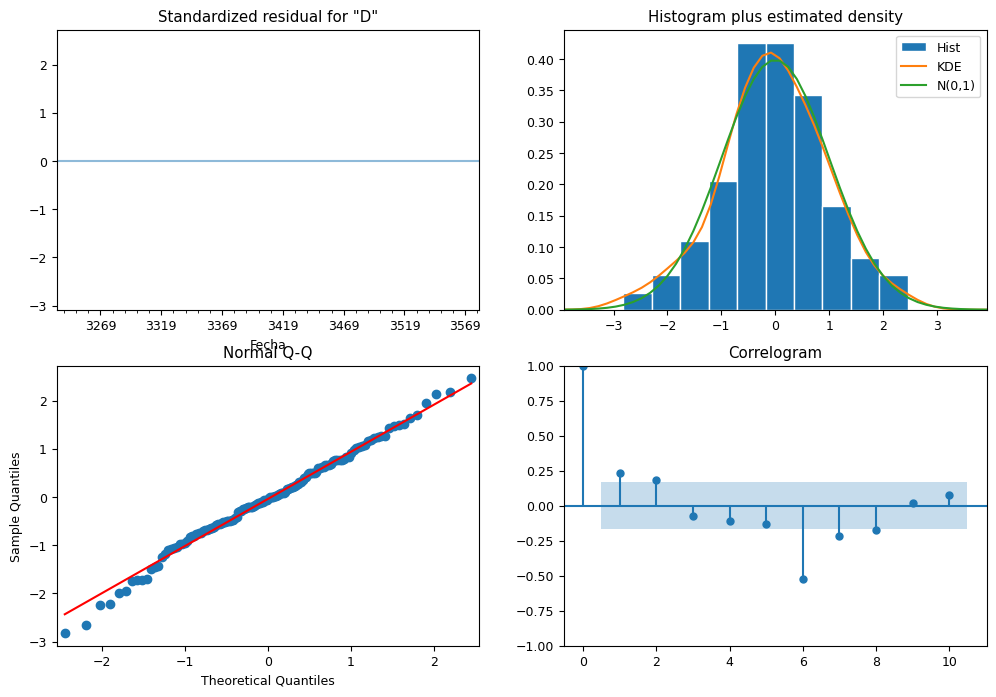

In [58]:
res_manual1.plot_diagnostics(figsize=(12,8))
plt.show()

In [59]:
adf(res_manual1.resid)

Estadístico T:  -17.036546258187393
p-valor:  8.253576053020602e-30
Estacionario


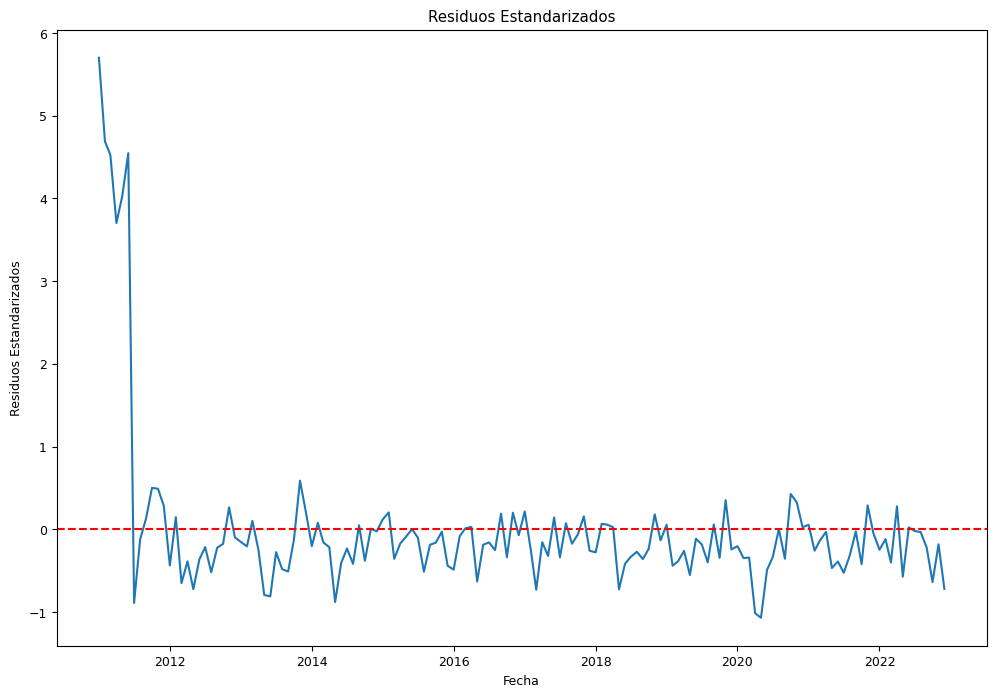

In [60]:
import seaborn as sns

residuos = res_manual1.resid
residuos_estandarizados = (residuos - np.mean(residuos)) / np.std(residuos)

plt.figure(figsize=(12, 8))
plt.plot(residuos.index, residuos_estandarizados)
plt.title('Residuos Estandarizados')
plt.xlabel('Fecha')
plt.ylabel('Residuos Estandarizados')
plt.axhline(0, color='red', linestyle='--')
plt.show()

#### Modelo 2:

In [61]:
manual2 = ARIMA(train['Demanda'], order=(1,0,0), seasonal_order=(1,1,0,3))
res_manual2 = manual2.fit()

In [62]:
print(res_manual2.summary())

                                    SARIMAX Results                                    
Dep. Variable:                         Demanda   No. Observations:                  144
Model:             ARIMA(1, 0, 0)x(1, 1, 0, 3)   Log Likelihood               -1759.128
Date:                         Tue, 12 Mar 2024   AIC                           3524.257
Time:                                 18:39:09   BIC                           3533.103
Sample:                             01-01-2011   HQIC                          3527.851
                                  - 12-01-2022                                         
Covariance Type:                           opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3940      0.052      7.641      0.000       0.293       0.495
ar.S.L3       -0.4799      0.033    -14.542      0.000     

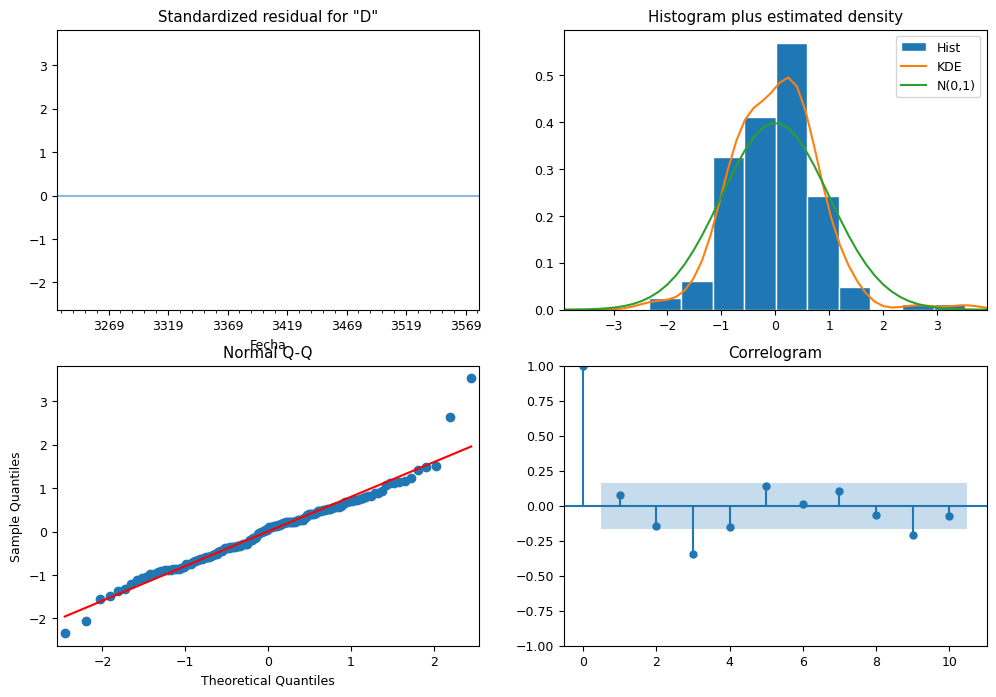

In [63]:
res_manual2.plot_diagnostics(figsize=(12,8))
plt.show()

In [64]:
adf(res_manual2.resid)

Estadístico T:  -7.521729940562668
p-valor:  3.775237882880491e-11
Estacionario


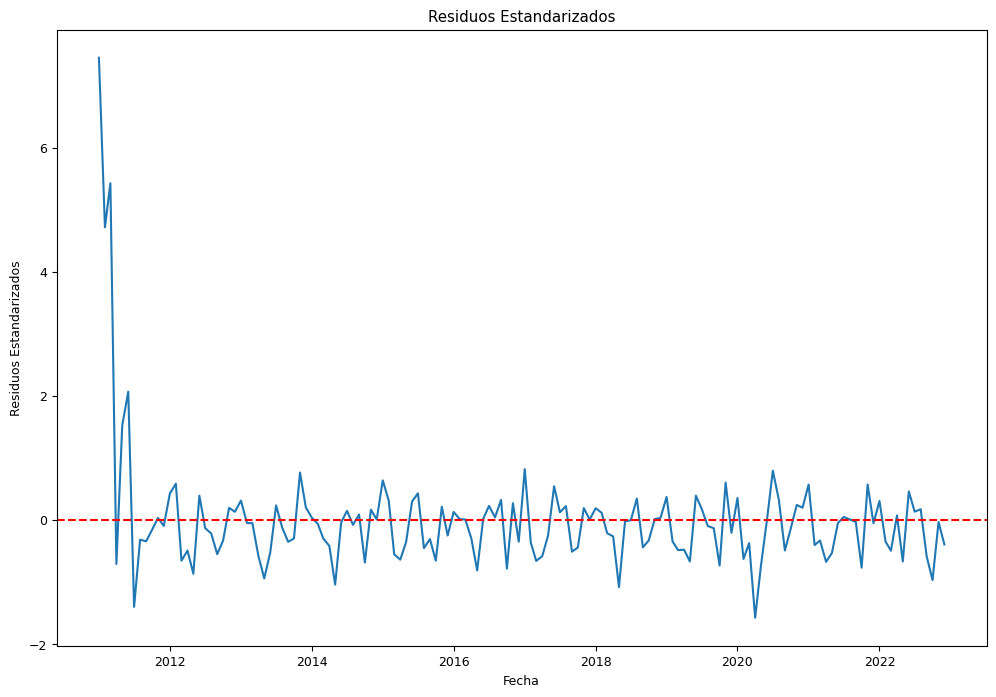

In [65]:
import seaborn as sns

residuos = res_manual2.resid
residuos_estandarizados = (residuos - np.mean(residuos)) / np.std(residuos)

plt.figure(figsize=(12, 8))
plt.plot(residuos.index, residuos_estandarizados)
plt.title('Residuos Estandarizados')
plt.xlabel('Fecha')
plt.ylabel('Residuos Estandarizados')
plt.axhline(0, color='red', linestyle='--')
plt.show()

In [66]:
train_pred_manual2 = res_manual2.predict()
real_train2 = train['Demanda']
print("RMSE para los datos TRAIN modelo manual2: ", mean_squared_error(real_train2, train_pred_manual2, squared=False))

forecast2_pred = res_manual2.get_forecast(N_test)
forecast2 = forecast2_pred.predicted_mean
print("RMSE para los datos TEST modelo manual2: ", mean_squared_error(test['Demanda'], forecast2, squared=False))

RMSE para los datos TRAIN modelo manual2:  123209.74476363591
RMSE para los datos TEST modelo manual2:  57602.56585219926


#### Modelo 3 con transformación Box-Cox:

In [67]:
from scipy.stats import boxcox
from scipy.stats import levene

In [68]:
grupos = df.groupby(df.index.year)['Demanda'].apply(list)

stat, p = levene(*grupos)

print('Estadístico de Levene:', stat)
print('P-valor:', p)

if p > 0.05:
    print('Las varianzas son iguales (no se rechaza la hipótesis nula).')
else:
    print('Las varianzas son diferentes (se rechaza la hipótesis nula).')

Estadístico de Levene: 0.5005128586815034
P-valor: 0.9116416489156975
Las varianzas son iguales (no se rechaza la hipótesis nula).


In [69]:
data, lamda3 =  boxcox(df['Demanda'])
lamda3

2.5472717710607555

In [70]:
df['boxcoxDemanda'] = data

Estadístico T:  -1.3231391391051854
p-valor:  0.6185207734257168
No estacionario


<Axes: xlabel='Fecha'>

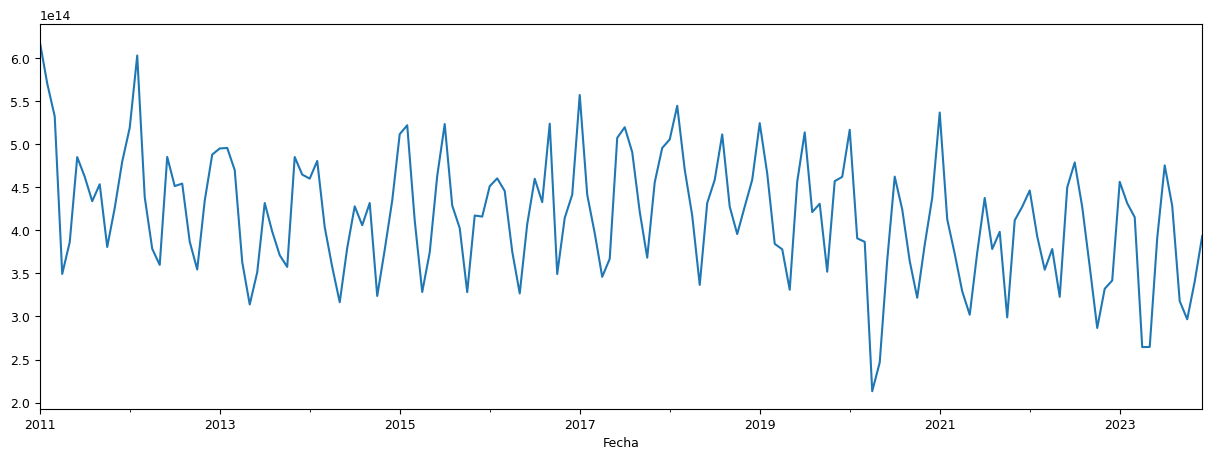

In [71]:
adf(df['boxcoxDemanda'])
df['boxcoxDemanda'].plot()

In [72]:
train = train.join(df['boxcoxDemanda'])

In [73]:
test = test.join(df['boxcoxDemanda'])

In [74]:
df['diffboxcoxDemanda'] = df['boxcoxDemanda'].diff()
adf(df['diffboxcoxDemanda'].dropna())

Estadístico T:  -10.00479027124606
p-valor:  1.8436718592975295e-17
Estacionario


In [75]:
train = train.join(df['diffboxcoxDemanda'])

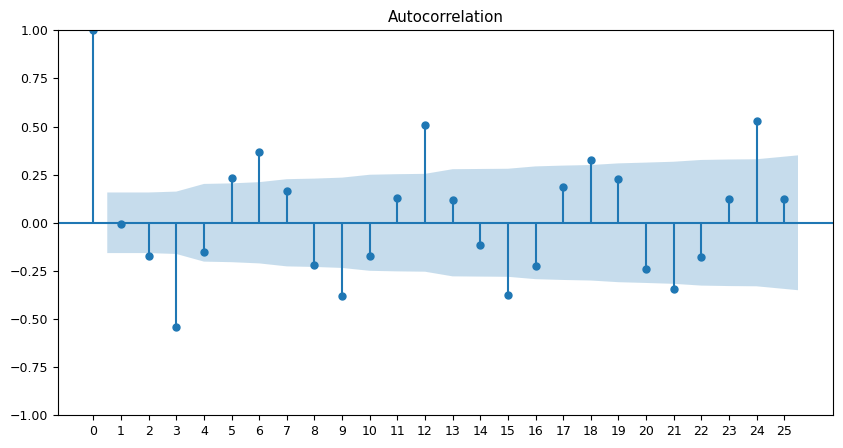

In [76]:
fig, ax = plt.subplots(figsize=(10,5))
plot_acf(df['diffboxcoxDemanda'].dropna(), ax = ax, lags=25)
ax.set_xticks(range(26))
ax.set_xticklabels(range(26))
plt.show()

C:\Users\Usuario\AppData\Roaming\Python\Python311\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


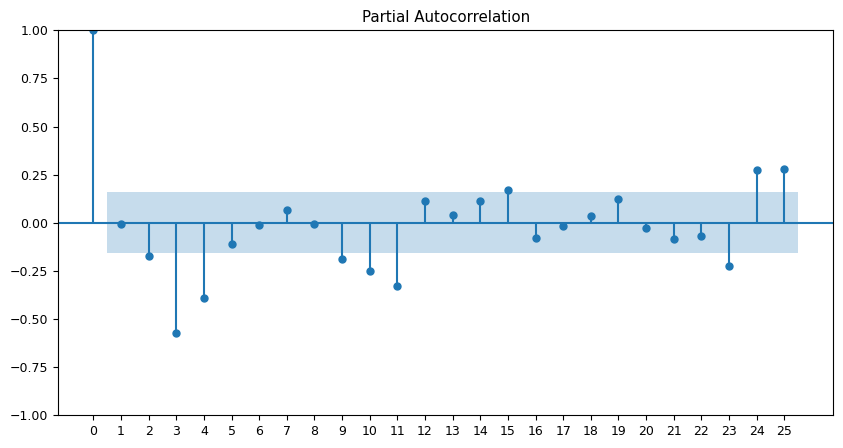

In [77]:
fig, ax = plt.subplots(figsize=(10,5))
plot_pacf(df['diffboxcoxDemanda'].dropna(), ax = ax, lags=25)
ax.set_xticks(range(26))
ax.set_xticklabels(range(26))
plt.show()

In [78]:
manual3 = ARIMA(train['boxcoxDemanda'], order=(1,1,0), seasonal_order=(0,1,1,6))
res_manual3 = manual3.fit()

In [79]:
res_manual3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                     boxcoxDemanda   No. Observations:                  144
Model:             ARIMA(1, 1, 0)x(0, 1, [1], 6)   Log Likelihood               -4536.970
Date:                           Tue, 12 Mar 2024   AIC                           9079.941
Time:                                   18:39:10   BIC                           9088.701
Sample:                               01-01-2011   HQIC                          9083.501
                                    - 12-01-2022                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3008      0.120     -2.507      0.012      -0.536      -0.066
ma.S.L6       -0.8300      0.146     -5.703      0.000      -1.115      -0.545
sigma2      5.271e+27   3.17e-30   1.66e+57      0.000    5.27e+27    5.27e+27
===================================================================================
Ljung-Box (L1) (Q):                   1.70   Jarque-Bera (JB):                 1.14
Prob(Q):                              0.19   Prob(JB):                         0.56
Heteroskedasticity (H):               0.59   Skew:                            -0.18
Prob(H) (two-sided):                  0.08   Kurtosis:                         3.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.1e+72. Standard errors may be unstable.
"""

In [80]:
train_pred_manual3 = res_manual3.predict(start=1)
real_train3 = train['boxcoxDemanda'][1:]
print("RMSE para los datos TRAIN modelo manual3: ", mean_squared_error(real_train3, train_pred_manual3, squared=False))

forecast3_pred = res_manual3.get_forecast(N_test)
forecast3 = forecast3_pred.predicted_mean
print("RMSE para los datos TRAIN modelo manual3: ", mean_squared_error(test['boxcoxDemanda'], forecast3, squared=False))

RMSE para los datos TRAIN modelo manual3:  63732368931606.84
RMSE para los datos TRAIN modelo manual3:  62110575199291.98


Para poder comparar con los modelos sin transformaciones, vamos a destransformar los datos:

In [81]:
from scipy.special import inv_boxcox

In [82]:
train_pred_manual3_inv = inv_boxcox(train_pred_manual3, lamda3)
real_train_original = train['Demanda'][1:]
rmse_train_original = mean_squared_error(real_train_original, train_pred_manual3_inv, squared=False)
print(f"RMSE para los datos TRAIN en la escala original: {rmse_train_original}")

forecast3_pred = res_manual3.get_forecast(N_test)
forecast3 = forecast3_pred.predicted_mean
forecast3_inv = inv_boxcox(forecast3, lamda3)
real_test_original = test['Demanda']
rmse_test_original = mean_squared_error(real_test_original, forecast3_inv, squared=False)
print(f"RMSE para los datos TEST en la escala original: {rmse_test_original}")

RMSE para los datos TRAIN en la escala original: 44828.73415255811
RMSE para los datos TEST en la escala original: 50358.95985374023


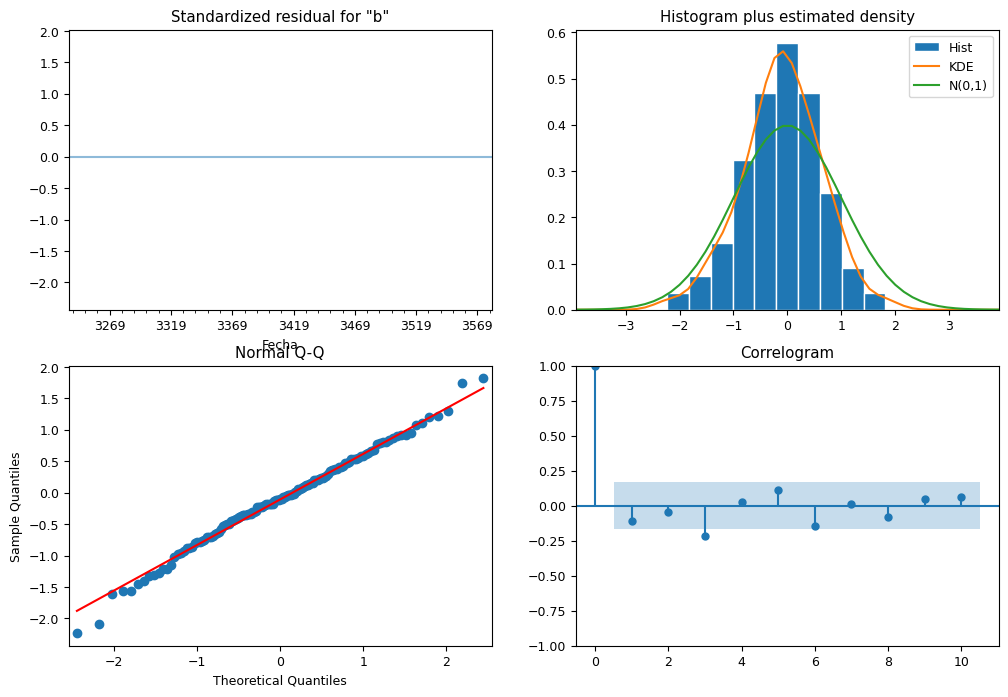

In [83]:
res_manual3.plot_diagnostics(figsize=(12,8))
plt.show()

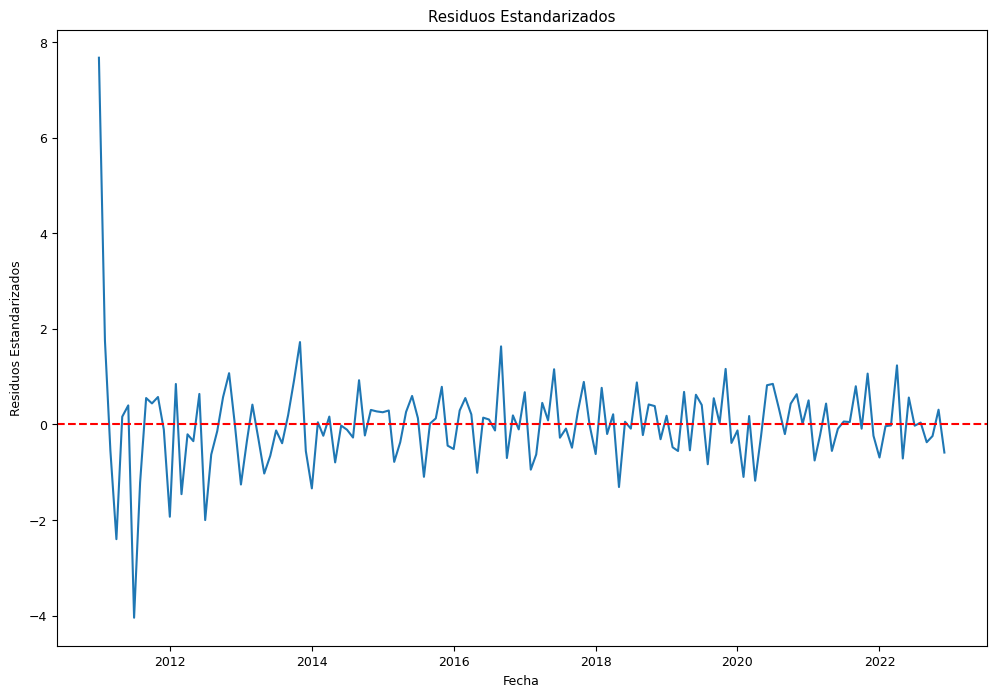

In [84]:
residuos3 = res_manual3.resid
residuos_estandarizados3 = (residuos3 - np.mean(residuos3)) / np.std(residuos3)

plt.figure(figsize=(12, 8))
plt.plot(residuos3.index, residuos_estandarizados3)
plt.title('Residuos Estandarizados')
plt.xlabel('Fecha')
plt.ylabel('Residuos Estandarizados')
plt.axhline(0, color='red', linestyle='--')
plt.show()

### 6. Ajustar un modelo ARIMA con ajuste automático. Comparar los resultados con el manual y elegir el mejor.  

In [85]:
import pmdarima as pm

#### Modelo AUTO ARIMA con los datos transformados:

In [86]:
modelo_auto1 = pm.auto_arima(train['boxcoxDemanda'],max_D=12, max_d=2, max_P=3, max_p=3,max_Q=3, max_q=3, max_order=14,m=12,trace=True, suppress_warnings=True, seasonal=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=9526.371, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=9495.986, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=9506.047, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=9524.486, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=9527.857, Time=0.01 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=9485.784, Time=0.09 sec
 ARIMA(1,1,0)(3,0,0)[12] intercept   : AIC=9484.983, Time=0.33 sec
 ARIMA(1,1,0)(3,0,1)[12] intercept   : AIC=9479.941, Time=0.52 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=9478.104, Time=0.16 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=9476.833, Time=0.07 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=9508.038, Time=0.03 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=9478.259, Time=0.16 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=9496.459, Time=0.08 sec
 ARIMA(1,1,0)(2,0,2)[12]

In [87]:
modelo_auto1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  144
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood               -4714.227
Date:                            Tue, 12 Mar 2024   AIC                           9438.453
Time:                                    18:39:25   BIC                           9453.267
Sample:                                01-01-2011   HQIC                          9444.473
                                     - 12-01-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4946      0.087      5.692      0.000       0.324       0.665
ma.L1         -0.9699      0.051    -19.200      0.000      -1.069      -0.871
ar.S.L12       0.9506      0.061     15.484      0.000       0.830       1.071
ma.S.L12      -0.8261      0.125     -6.589      0.000      -1.072      -0.580
sigma2      3.205e+27   1.59e-29   2.02e+56      0.000     3.2e+27     3.2e+27
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):                 0.97
Prob(Q):                              0.71   Prob(JB):                         0.62
Heteroskedasticity (H):               0.63   Skew:                             0.14
Prob(H) (two-sided):                  0.11   Kurtosis:                         3.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.58e+72. Standard errors may be unstable.
"""

In [88]:
test_pred , confint = modelo_auto1.predict(n_periods=N_test, return_conf_int=True)

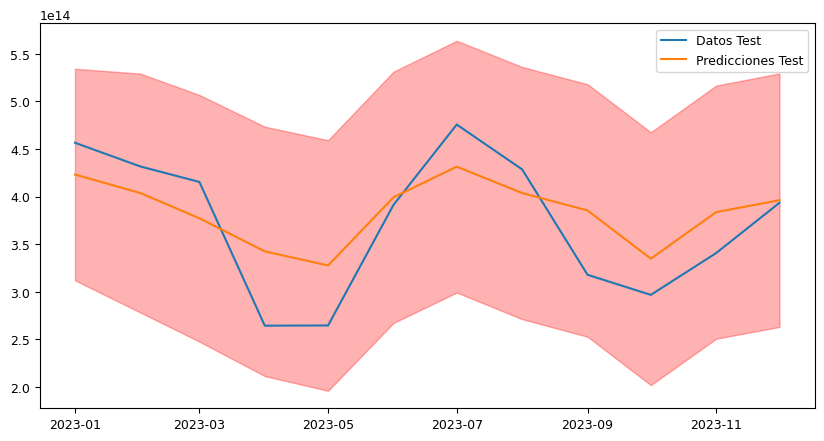

In [89]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(test.index, test['boxcoxDemanda'], label='Datos Test')
ax.plot(test.index, test_pred, label='Predicciones Test')
ax.fill_between(test.index, confint[:,0], confint[:,1], color='red', alpha=0.3)
ax.legend()

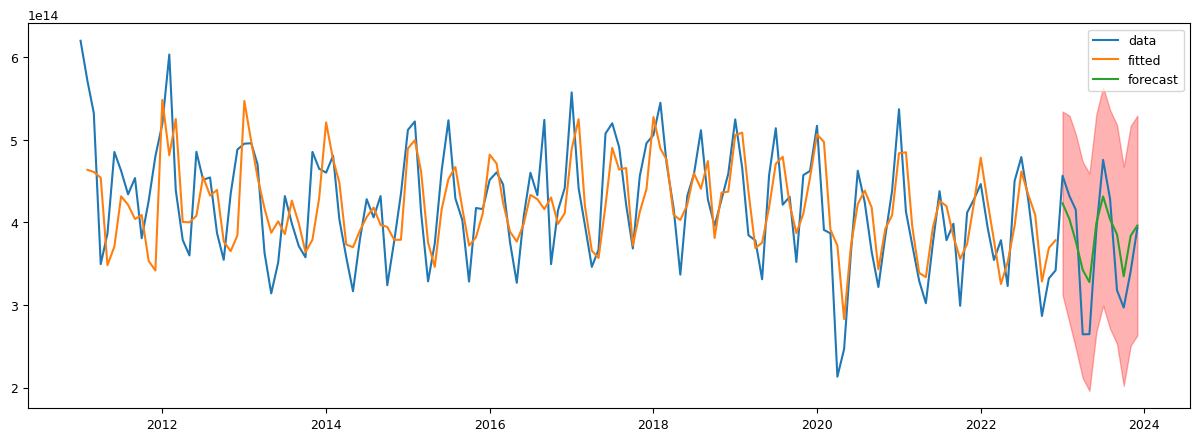

In [90]:
train_pred = modelo_auto1.predict_in_sample(start=1, end=-1)
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(df.index, df['boxcoxDemanda'], label='data')
ax.plot(train.index[1:], train_pred, label='fitted')
ax.plot(test.index, test_pred, label='forecast')
ax.fill_between(test.index, confint[:,0], confint[:,1], color='red', alpha=0.3)
ax.legend()

In [91]:
train_pred_auto1_inv = inv_boxcox(train_pred ,lamda3)
forecast_auto1_inv = inv_boxcox(test_pred, lamda3)

real_train_original_auto1 = train['Demanda'][1:]  
real_test_original_auto1 = test['Demanda']

rmse_train_original_auto1 = mean_squared_error(real_train_original_auto1, train_pred_auto1_inv,squared=False)
print(f"RMSE para los datos TRAIN en la escala original: {rmse_train_original_auto1}")

rmse_test_original_auto1 = mean_squared_error(real_test_original_auto1, forecast_auto1_inv, squared=False)
print(f"RMSE para los datos TEST en la escala original: {rmse_test_original_auto1}")

RMSE para los datos TRAIN en la escala original: 37367.4422870198
RMSE para los datos TEST en la escala original: 37745.779442195984


#### Modelo AUTOARIMA con los datos sin transformar:

In [92]:
modelo_auto2 = pm.auto_arima(train['Demanda'],start_p=1,start_q=1,m=12,trace=True, suppress_warnings=True, seasonal=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=3473.737, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=3519.252, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=3505.166, Time=0.05 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=3508.392, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=3517.349, Time=0.01 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=3504.706, Time=0.10 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=3500.607, Time=0.11 sec
 ARIMA(1,1,1)(2,0,1)[12] intercept   : AIC=3475.510, Time=0.39 sec
 ARIMA(1,1,1)(1,0,2)[12] intercept   : AIC=3475.534, Time=0.38 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=3520.803, Time=0.05 sec
 ARIMA(1,1,1)(0,0,2)[12] intercept   : AIC=3497.572, Time=0.22 sec
 ARIMA(1,1,1)(2,0,0)[12] intercept   : AIC=3492.814, Time=0.24 sec
 ARIMA(1,1,1)(2,0,2)[12] intercept   : AIC=inf, Time=0.70 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(1,1,0)(1,0,1)[12] inte

In [93]:
modelo_auto2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  144
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood               -1730.869
Date:                            Tue, 12 Mar 2024   AIC                           3473.737
Time:                                    18:39:29   BIC                           3491.514
Sample:                                01-01-2011   HQIC                          3480.961
                                     - 12-01-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -1088.8114   1049.632     -1.037      0.300   -3146.052     968.429
ar.L1         -0.7330      0.226     -3.243      0.001      -1.176      -0.290
ma.L1          0.6806      0.256      2.664      0.008       0.180       1.181
ar.S.L12       0.9426      0.049     19.108      0.000       0.846       1.039
ma.S.L12      -0.8559      0.075    -11.364      0.000      -1.004      -0.708
sigma2      1.866e+09      0.001   1.85e+12      0.000    1.87e+09    1.87e+09
===================================================================================
Ljung-Box (L1) (Q):                   2.63   Jarque-Bera (JB):                 1.83
Prob(Q):                              0.11   Prob(JB):                         0.40
Heteroskedasticity (H):               0.73   Skew:                            -0.27
Prob(H) (two-sided):                  0.27   Kurtosis:                         2.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.26e+27. Standard errors may be unstable.
"""

In [94]:
test_pred2 , confint2 = modelo_auto2.predict(n_periods=N_test, return_conf_int=True)

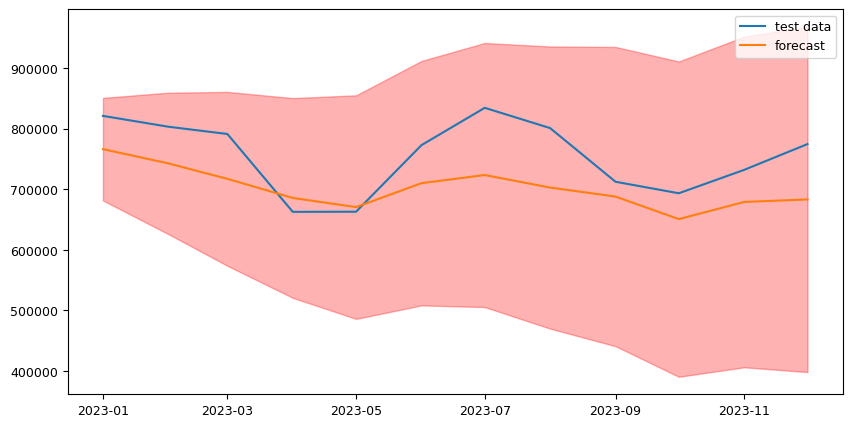

In [95]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(test.index, test['Demanda'], label='test data')
ax.plot(test.index, test_pred2, label='forecast')
ax.fill_between(test.index, confint2[:,0], confint2[:,1], color='red', alpha=0.3)
ax.legend()

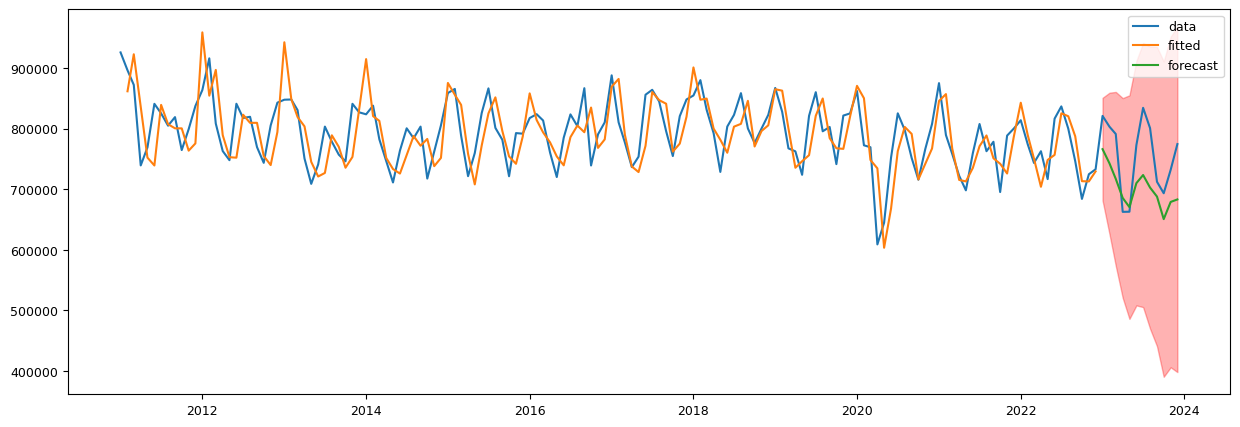

In [96]:
train_pred2 = modelo_auto2.predict_in_sample(start=1, end=-1)
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(df.index, df['Demanda'], label='data')
ax.plot(train.index[1:], train_pred2, label='fitted')
ax.plot(test.index, test_pred2, label='forecast')
ax.fill_between(test.index, confint2[:,0], confint2[:,1], color='red', alpha=0.3)
ax.legend()

In [97]:
rmse_train_original_auto2 = mean_squared_error(train['Demanda'][1:], train_pred2,squared=False)
print(f"RMSE para los datos TRAIN en la escala original: {rmse_train_original_auto2}")

rmse_test_original_auto2 = mean_squared_error(test['Demanda'], test_pred2, squared=False)
print(f"RMSE para los datos TEST en la escala original: {rmse_test_original_auto2}")

RMSE para los datos TRAIN en la escala original: 43790.78728572264
RMSE para los datos TEST en la escala original: 65964.55220016523


### 8. Calcular las predicciones y los intervalos de confianza para las unidades de tiempo que se considere oportuno, dependiendo de la serie, siguientes al último valor observado. Representarlas gráficamente.

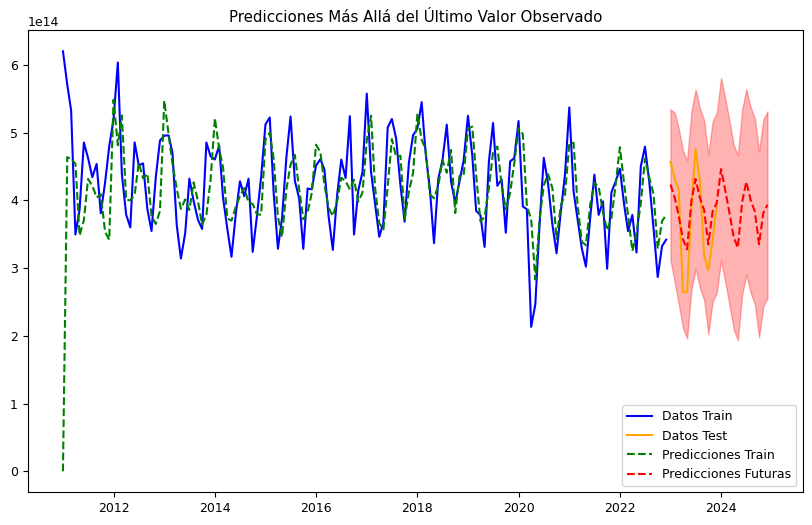

In [98]:
in_sample_forecast = modelo_auto1.predict_in_sample()
in_sample_index = train.index

n_extras = 24
forecast, confint = modelo_auto1.predict(n_periods=n_extras, return_conf_int=True)
ultima_fecha = train.index[-1]
pred_index = pd.date_range(start=ultima_fecha, periods=n_extras + 1, freq='MS')[1:] 

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(train.index, train['boxcoxDemanda'], label='Datos Train', color='blue')
ax.plot(test.index, test['boxcoxDemanda'], label='Datos Test', color='orange')
ax.plot(in_sample_index, in_sample_forecast, label='Predicciones Train', color='green', linestyle='--')
ax.plot(pred_index, forecast, label='Predicciones Futuras', color='red', linestyle='--')
ax.fill_between(pred_index, confint[:, 0], confint[:, 1], color='red', alpha=0.3)
ax.set_title('Predicciones Más Allá del Último Valor Observado')
ax.legend(loc='lower right')

plt.show()